In [11]:
import pandas as pd
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor

In [2]:
agol = GIS(profile='adoezema_AGO')
print(agol.users.me.username)

adoezema


<Item title:"DWSD Asset Locating 0051210010 Hosted" type:Feature Layer Collection owner:mmarks_ohm>
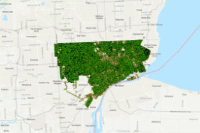

In [3]:
field_data = agol.content.get(itemid='3b9b6fda7d864e3bb804a7bbcd82f702')
field_data

Query unsound records from data

In [14]:
field_data.layers[0].query(where="CONDITION<>'Sound'", as_df=True)['CONDITION']

0                  Sinkhole
1                   Damaged
2                   Damaged
3                   Damaged
4                   Damaged
5    Major Sediment Buildup
6             Safety Issues
7    Major Sediment Buildup
8             Safety Issues
Name: CONDITION, dtype: object